# Regression with an Insurance Dataset
# Playground Series - Season 4, Episode 12

## Using XGB Regressor

# Importing Required Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Training Data

In [2]:
dataset = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
dataset.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [3]:
print(dataset.shape)

print(dataset.columns)

(1200000, 21)
Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')


In [4]:
dataset.dtypes.value_counts()


object     11
float64     9
int64       1
Name: count, dtype: int64

In [5]:
datatypes = dataset.columns.to_series().groupby(dataset.dtypes).groups
datatypes

{int64: ['id'], float64: ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount'], object: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']}

In [6]:
# Dropping id from dataset

dataset.drop(['id'], axis=1, inplace = True)

In [7]:
# Converting Policy Start Date

dataset[['Date', 'Time']] = dataset['Policy Start Date'].str.split(' ', expand=True)
dataset[['Year', 'Month','Day']] = dataset['Date'].str.split('-', expand=True)
dataset[['Hour', 'Minutes','seconds']] = dataset['Time'].str.split(':', expand=True)


In [8]:
dataset.drop(['Policy Start Date','Date', 'Time'], axis=1, inplace = True)

In [9]:
dataset[['Year', 'Month', 'Day', 'Hour', 'Minutes' ]] = dataset[['Year', 'Month', 'Day', 'Hour', 'Minutes']].astype(int)
dataset[['seconds']] = dataset[['seconds']].astype(float)

In [10]:
# Converting Categorical Values

dataset[['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']] = dataset[['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']].apply(LabelEncoder().fit_transform)

In [11]:
# Check for NAN values

dataset.isna().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status               0
Number of Dependents    109672
Education Level              0
Occupation                   0
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Customer Feedback            0
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
Year                         0
Month                        0
Day                          0
Hour                         0
Minutes                      0
seconds                      0
dtype: int64

In [12]:
# Filling NaN values with mean

for i in dataset.columns[dataset.isnull().any(axis=0)]:    
    dataset[i].fillna(dataset[i].mean(),inplace=True)

In [13]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1200000.0,41.145563,13.434008,18.000000,30.000000,41.145563,53.000000,64.000000
Gender,1200000.0,0.502143,0.499996,0.000000,0.000000,1.000000,1.000000,1.000000
Annual Income,1200000.0,32745.217777,31571.071706,1.000000,8646.000000,24996.000000,43936.000000,149997.000000
Marital Status,1200000.0,1.033904,0.846509,0.000000,0.000000,1.000000,2.000000,3.000000
Number of Dependents,1200000.0,2.009934,1.351019,0.000000,1.000000,2.000000,3.000000,4.000000
Education Level,1200000.0,1.506332,1.123030,0.000000,0.000000,2.000000,3.000000,3.000000
Occupation,1200000.0,1.591608,1.144400,0.000000,1.000000,2.000000,3.000000,3.000000
Health Score,1200000.0,25.613908,11.820802,2.012237,16.554572,25.613908,33.772890,58.975914
Location,1200000.0,0.997137,0.815705,0.000000,0.000000,1.000000,2.000000,2.000000
Policy Type,1200000.0,1.002743,0.816696,0.000000,0.000000,1.000000,2.000000,2.000000


# Data Visualisation

(25.5, -0.5)

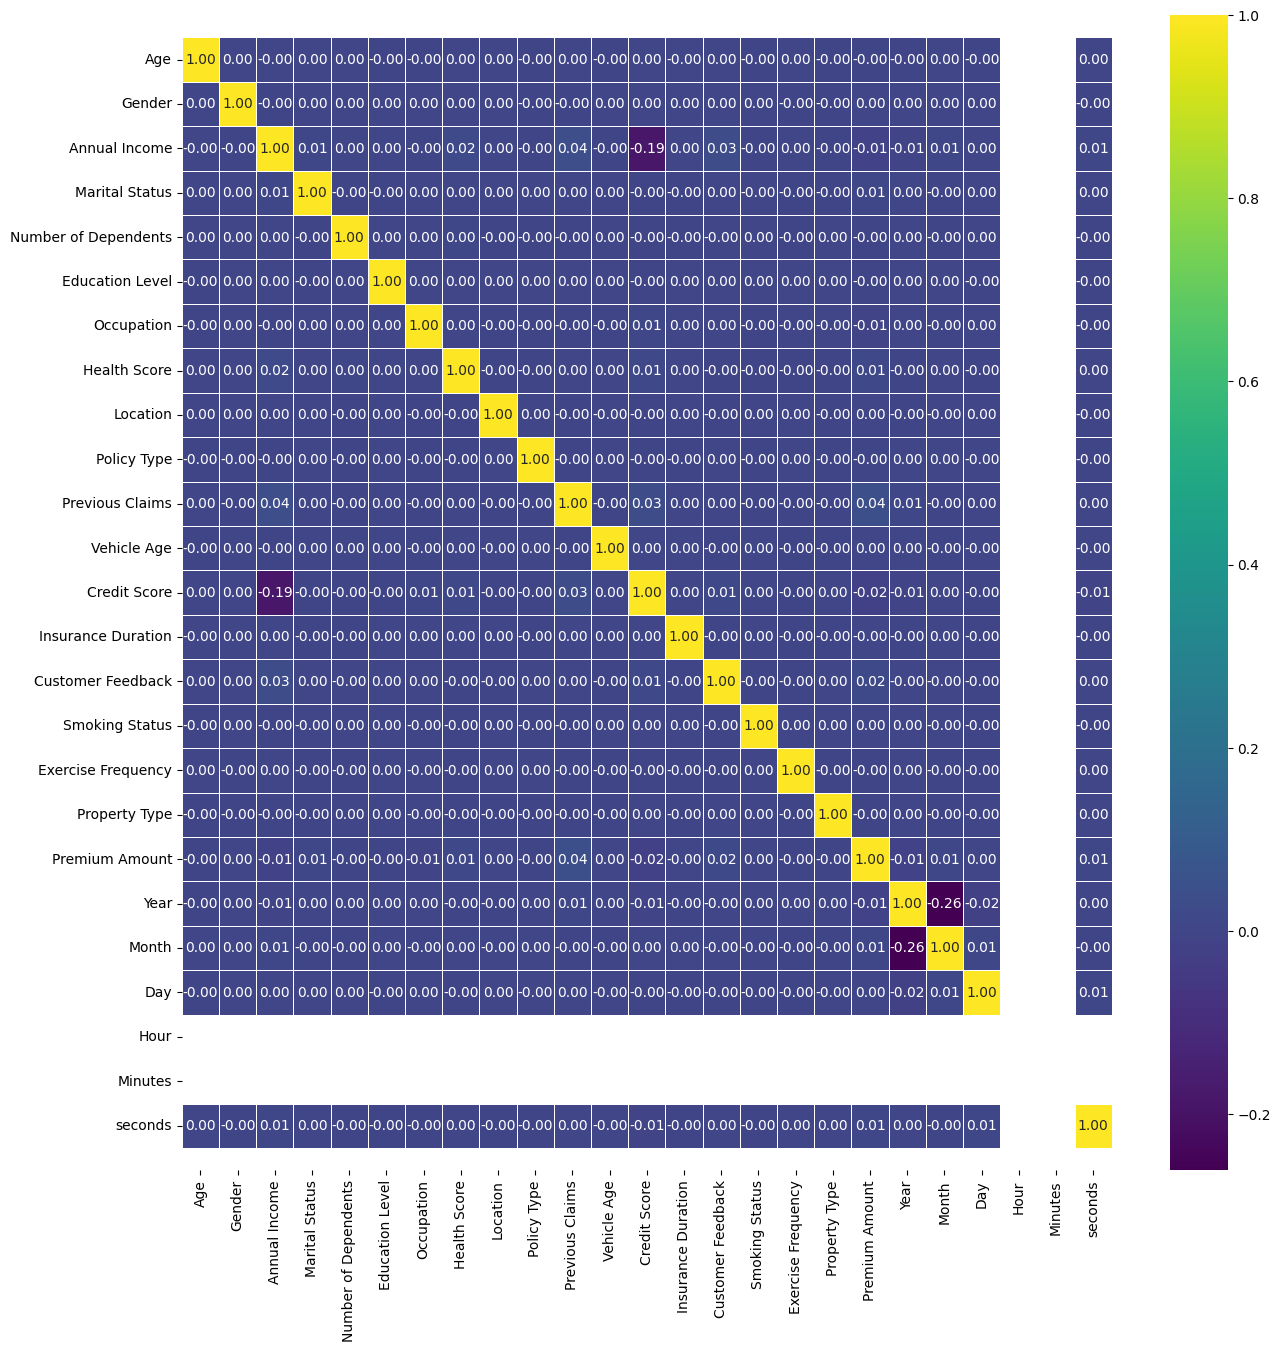

In [14]:
corr_matrix = dataset.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5,fmt=".2f", cmap="viridis");                                  
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [15]:
# Dropping Columns Hour and Minute as they have same unique values

dataset.drop(['Hour', 'Minutes'], axis=1, inplace = True)

In [16]:
dataset = dataset.rename(columns={'Premium Amount': 'Premium_Amount'})

<Axes: title={'center': 'Correlation with Premium Amount '}>

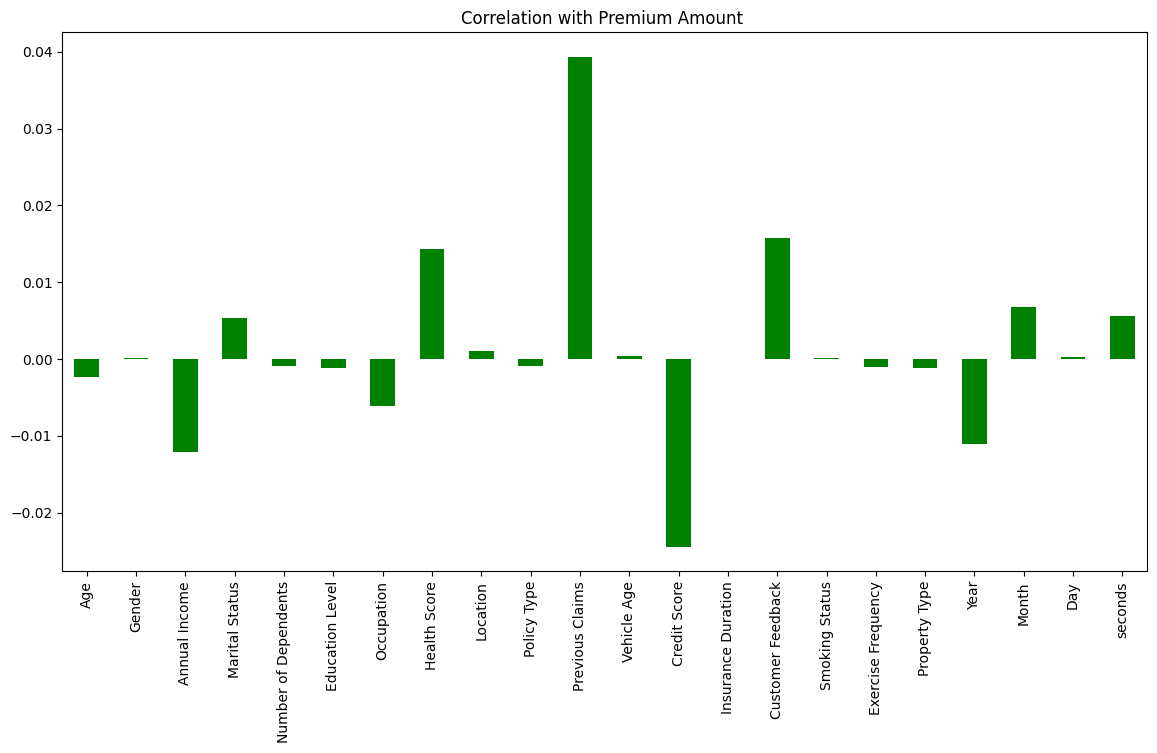

In [17]:
dataset.drop('Premium_Amount', axis=1).corrwith(dataset.Premium_Amount).plot(kind='bar', color='Green', figsize=(14, 7), title="Correlation with Premium Amount ")


In [18]:
dataset

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium_Amount,Year,Month,Day,seconds
0,19.0,0,10049.000000,1,1.000000,0,1,22.598761,2,2,...,5.0,2,0,3,2,2869.0,2023,12,23,39.134960
1,39.0,0,31678.000000,0,3.000000,2,3,15.569731,0,1,...,2.0,0,1,1,2,1483.0,2023,6,12,39.111551
2,23.0,1,25602.000000,0,3.000000,1,1,47.177549,1,2,...,3.0,1,1,3,2,567.0,2023,9,30,39.221386
3,21.0,1,141855.000000,1,2.000000,0,3,10.938144,0,0,...,1.0,2,1,0,0,765.0,2024,6,12,39.226954
4,21.0,1,39651.000000,2,1.000000,0,1,20.376094,0,2,...,4.0,2,1,3,2,2022.0,2021,12,1,39.252145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,0,27316.000000,1,0.000000,2,2,13.772907,2,2,...,3.0,2,0,0,0,1303.0,2023,5,3,39.257696
1199996,54.0,1,35786.000000,0,2.009934,2,1,11.483482,0,1,...,4.0,2,0,3,0,821.0,2022,9,10,39.134960
1199997,19.0,1,51884.000000,0,0.000000,2,3,14.724469,1,0,...,6.0,1,0,1,1,371.0,2021,5,25,39.106582
1199998,55.0,1,32745.217777,2,1.000000,3,3,18.547381,1,2,...,4.0,2,0,0,0,596.0,2021,9,19,39.190215


In [19]:
# Choosing X and y 

X = dataset.drop('Premium_Amount', axis=1)
y = dataset.Premium_Amount

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# Test Data

In [21]:
dataset_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')
dataset_test1 = dataset_test.copy()

dataset_test.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [22]:
# Dropping id from dataset

dataset_test.drop(['id'], axis=1, inplace = True)

In [23]:
# Converting Policy Start Date

dataset_test[['Date', 'Time']] = dataset_test['Policy Start Date'].str.split(' ', expand=True)
dataset_test[['Year', 'Month','Day']] = dataset_test['Date'].str.split('-', expand=True)
dataset_test[['Hour', 'Minutes','seconds']] = dataset_test['Time'].str.split(':', expand=True)

In [24]:
dataset_test.drop(['Policy Start Date','Date', 'Time'], axis=1, inplace = True)

In [25]:
dataset_test[['Year', 'Month', 'Day', 'Hour', 'Minutes' ]] = dataset_test[['Year', 'Month', 'Day', 'Hour', 'Minutes']].astype(int)
dataset_test[['seconds']] = dataset_test[['seconds']].astype(float)

In [26]:
dataset_test.drop(['Hour', 'Minutes'], axis=1, inplace = True)

In [27]:
# Converting Categorical Values

dataset_test[['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']] = dataset_test[['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']].apply(LabelEncoder().fit_transform)

In [28]:
# Check for NAN values

dataset_test.isna().sum()

Age                      12489
Gender                       0
Annual Income            29860
Marital Status               0
Number of Dependents     73130
Education Level              0
Occupation                   0
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Customer Feedback            0
Smoking Status               0
Exercise Frequency           0
Property Type                0
Year                         0
Month                        0
Day                          0
seconds                      0
dtype: int64

In [29]:
# Filling NaN values with mean

for i in dataset_test.columns[dataset_test.isnull().any(axis=0)]:    
    dataset_test[i].fillna(dataset_test[i].mean(),inplace=True)

# Machine Learning

### XGB Regressor model

In [30]:
reg = xgb.XGBRegressor(learning_rate =0.1, n_estimators=1500, max_depth=5, min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'reg:linear',nthread=4,scale_pos_weight=1,seed=27)

In [31]:
reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None, nthread=4,
             num_parallel_tree=None, ...)

In [32]:
pred_t = reg.predict(X_test)

# Evaluation

### R-Squared Error

In [33]:
print("R^2 on training  data ",reg.score(X_train, y_train))
print("R^2 on testing data ",reg.score(X_test,y_test))

R^2 on training  data  0.10654766530671111
R^2 on testing data  0.05457564684654126


### RMSE

In [34]:
mse = mean_squared_error(y_test, pred_t)
rmse = np.sqrt(mse)
rmse


840.8674690784438

# Prediction

In [35]:
pred_xgb = reg.predict(dataset_test)

In [36]:
pred = pd.DataFrame(pred_xgb, columns=['Premium Amount'])
output = pd.concat([dataset_test1['id'],pred],axis=1).set_index(['id'])

In [37]:
output

,Premium Amount
id,
1200000,1235.064941
1200001,1095.136841
1200002,1005.883484
1200003,1089.815186
1200004,1074.664795
...,...
1999995,1277.291138
1999996,1459.739136
1999997,1221.691895


In [38]:
output.to_csv('submission.csv')